## Week 6
#### John Isak F. Villanger.
#### Questions:
2. Do you expect the classification to be as easy as the MNIST-dataset?
The classification here seems to be harder than MNIST, generally numbers can be recognized by recognizing lines and
circles and then knowing the relations between lines and circles constitue each number. Here you will just get some blob,
and the blob for each thing will have different shape depending on the angle.

5. Visualize overfitting?
You can see train validation accuracy/loss for the two models at the bottom.
Training accuracy seems to steadily improve across the epochs, while validation accuracy seems to plateau around 63%.
You can see some signs of overfitting in the loss graph, where it starts to increase for the validation data.

7. Were the strategies successful in coping with overfitting?
I use L2 regularization on Adam by adjusting the weight-decay parameter(set it to 0.001). From the pytorch documentation,
this is an L2 regularization optimized for Adam. For data augmentation, i flipped the image horizontally with a p=0.5.
I also randomly erased some of the pixels in the image, this seems to be equivalent to using dropout in the input layer.
These strategies where definitely successful in improving the models performance on the validation data, you also see
fewer signs of overfitting on the loss graph for the validation data, where it is steadily decreasing across all the epochs.
It's imporant to note that you can't compare the training-val relation between the strategies being included or not,
since the image augmentation will reduce performance on the training data.

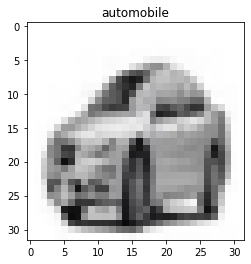

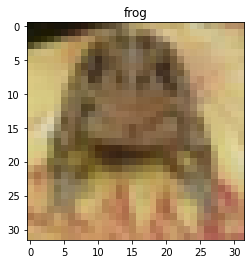

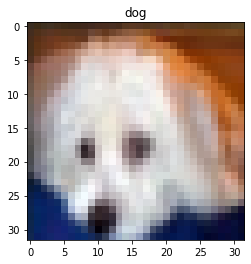

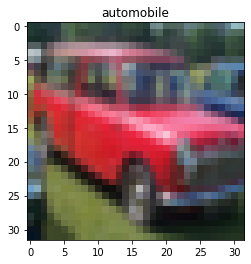

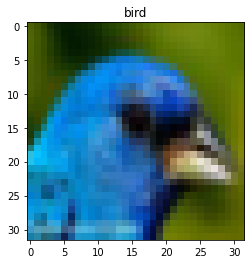

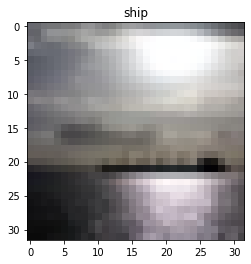

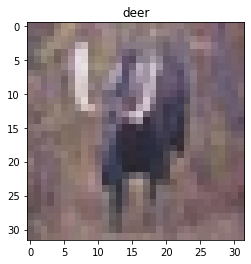

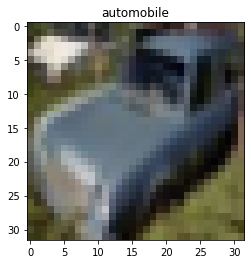

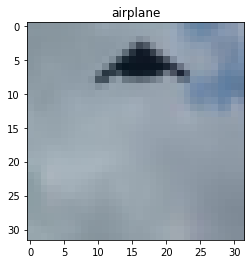

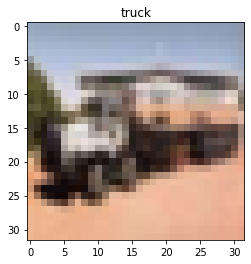

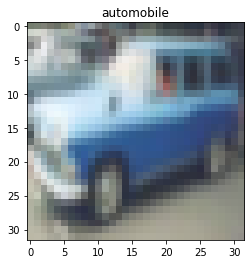

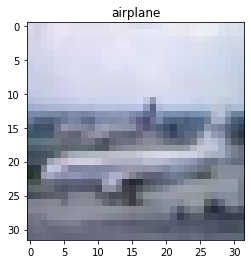

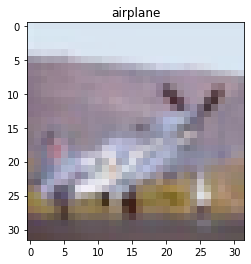

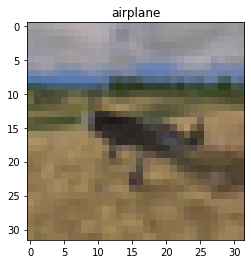

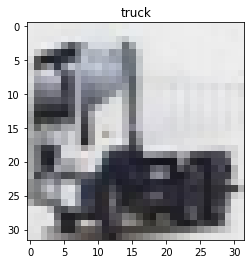

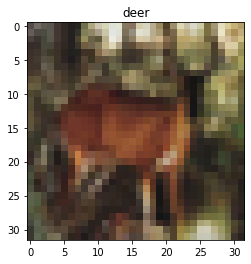

epoch 1
Training Loss: 1.6377 Acc: 0.3968
Validation Loss: 1.4543 Acc: 0.4840
epoch 2
Training Loss: 1.3054 Acc: 0.5298
Validation Loss: 1.2923 Acc: 0.5358
epoch 3
Training Loss: 1.1801 Acc: 0.5800
Validation Loss: 1.1711 Acc: 0.5796
epoch 4
Training Loss: 1.0954 Acc: 0.6125
Validation Loss: 1.1547 Acc: 0.5932
epoch 5
Training Loss: 1.0359 Acc: 0.6328
Validation Loss: 1.1102 Acc: 0.6054
epoch 6
Training Loss: 0.9828 Acc: 0.6517
Validation Loss: 1.0620 Acc: 0.6238
epoch 7
Training Loss: 0.9402 Acc: 0.6707
Validation Loss: 1.1329 Acc: 0.6054
epoch 8
Training Loss: 0.9070 Acc: 0.6806
Validation Loss: 1.0302 Acc: 0.6372
epoch 9
Training Loss: 0.8761 Acc: 0.6919
Validation Loss: 1.0557 Acc: 0.6412
epoch 10
Training Loss: 0.8511 Acc: 0.6985
Validation Loss: 1.0574 Acc: 0.6364
epoch 11
Training Loss: 0.8280 Acc: 0.7083
Validation Loss: 1.0312 Acc: 0.6498
epoch 12
Training Loss: 0.8045 Acc: 0.7162
Validation Loss: 1.0567 Acc: 0.6356
epoch 13
Training Loss: 0.7869 Acc: 0.7221
Validation Loss: 1

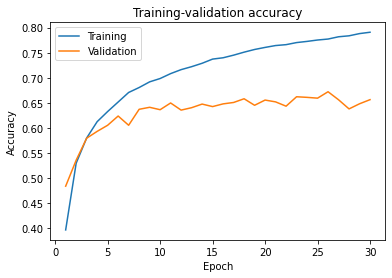

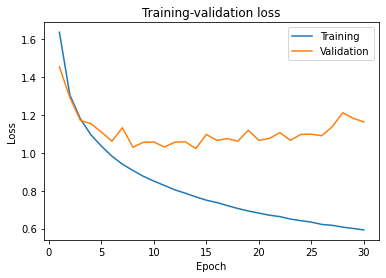

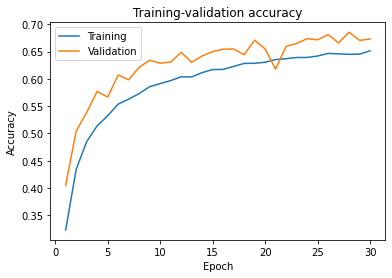

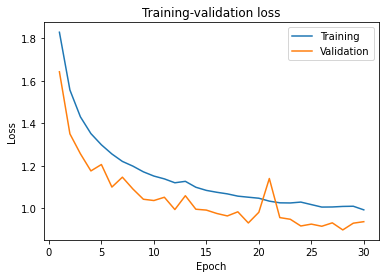

In [2]:
import torch
import torchvision
import numpy as np
import torchvision.transforms as transf
import matplotlib.pyplot as plt
import copy
import torch.nn as nn

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")


def data_augmentation():
    augmentations = transf.Compose([
        transf.RandomHorizontalFlip(),
        transf.RandomErasing(),
    ])
    return augmentations


def show_images(trainloader, classes):
    dataiter = iter(trainloader)
    images_b, labels_b = dataiter.next()
    for idx, image in enumerate(images_b):
        plt.imshow(images_b[idx].numpy().transpose(1, 2, 0))
        plt.title(classes[labels_b[idx]])
        plt.show()

def make_model():
    model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5), #28x28
        nn.MaxPool2d(2, stride=2, padding=0), #14x14
        nn.Conv2d(12, 24, 3), #12x12
        nn.MaxPool2d(2, stride=2, padding=0), #6x6
        nn.Conv2d(24, 42, 3), #4x4
        nn.MaxPool2d(2, stride=2, padding=0), #2x2
        nn.Flatten(),
        nn.Linear(168, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 10)
    )
    return model

def make_model_2():
    model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5), #28x28
        nn.MaxPool2d(2, stride=2, padding=0), #14x14
        nn.Conv2d(12, 24, 3), #12x12
        nn.MaxPool2d(2, stride=2, padding=0), #6x6
        nn.Conv2d(24, 42, 3), #4x4
        nn.MaxPool2d(2, stride=2, padding=0), #2x2
        nn.Flatten(),
        nn.Linear(168, 64),
        nn.ReLU(),
        # nn.Dropout(0.2),
        nn.Linear(64, 32),
        nn.ReLU(),
        # nn.Dropout(0.1),
        nn.Linear(32, 10)
    )
    return model

def main():
    images = torchvision.datasets.CIFAR10("CIFAR10", train=True, transform=transf.ToTensor(), download=False)
    train, val = torch.utils.data.random_split(images, [45000, 5000])


    train_loader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val, batch_size=1)

    show_images(train_loader, images.classes)

    model = make_model()
    adam = torch.optim.Adam(model.parameters())
    cross_entropy = nn.CrossEntropyLoss()
    model, train_acc, train_loss, val_acc, val_loss = train_model(model,cross_entropy, adam, 30, train_loader,
                                                                  val_loader, None)
    make_plots(train_acc, train_loss, val_acc, val_loss)

    model_2 = make_model_2()
    adam_2 = torch.optim.Adam(model_2.parameters(), weight_decay=0.001)
    model_2, train_acc_2, train_loss_2, val_acc_2, val_loss_2 = train_model(model_2, cross_entropy, adam_2, 30,
                                                                            train_loader, val_loader, data_augmentation())
    make_plots(train_acc_2, train_loss_2, val_acc_2, val_loss_2)



def make_plots(train_acc, train_loss, val_acc, val_loss):
    fig, ax = plt.subplots()
    ax.plot(np.arange(1,len(train_acc)+1),train_acc, label="Training")
    ax.plot(np.arange(1,len(val_acc)+1),val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training-validation accuracy")
    plt.legend()
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(np.arange(1,len(train_loss)+1), train_loss, label="Training")
    ax.plot(np.arange(1,len(val_loss)+1),val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training-validation loss")
    plt.legend()
    plt.show()

def train_model(model, loss_f, optimizer, num_epochs, train, val, augmentations):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_size = len(train.dataset)
    train_loss = np.zeros(num_epochs)
    train_acc = np.zeros(num_epochs)
    val_size = len(val.dataset)
    val_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    for epoch in range(num_epochs):
        print("epoch",epoch+1)
        running_loss = 0.0
        running_corrects = 0
        torch.set_grad_enabled(True)
        for batch_idx, batch in enumerate(train):
            model.train()
            inputs, labels = batch
            if (augmentations != None):
                inputs = augmentations(inputs)
            inputs.to(device)
            labels.to(device)

            #Forward
            out = model(inputs)
            _, preds = torch.max(out, 1)

            #Compute objective function
            loss = loss_f(out, labels)

            #Clean the gradients
            model.zero_grad()

            #Accumulate partial deriviates wrt parameters
            loss.backward()

            #Step in the opposite direction og the gradient wrt optimizer
            optimizer.step()

            #stats
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_loss[epoch] = running_loss / train_size
        train_acc[epoch] = running_corrects / train_size
        print('Training Loss: {:.4f} Acc: {:.4f}'.format(train_loss[epoch], train_acc[epoch]))
        torch.set_grad_enabled(False)
        running_loss = 0.0
        running_corrects = 0
        #torch.set_grad_enabled(False)
        for batch_idx, batch in enumerate(val):
            model.eval()
            inputs, labels = batch

            #Move to gpu if availible
            inputs.to(device)
            labels.to(device)

            #Forward
            out = model(inputs)
            _, preds = torch.max(out,1)

            #Compute objective function
            loss = loss_f(out, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        val_loss[epoch] = running_loss / val_size
        val_acc[epoch] = running_corrects / val_size

        print('Validation Loss: {:.4f} Acc: {:.4f}'.format(val_loss[epoch], val_acc[epoch]))

        # deep copy the model
        if (val_acc[epoch] > best_acc):
            best_acc = val_acc[epoch]
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    print('Best val Acc: {:4f}'.format(best_acc))
    return model, train_acc, train_loss, val_acc, val_loss


main()

